## Step 1: Install required libraries

In [1]:
!pip install -qU datasets llama-index llama-index-llms-openai llama-index-vector-stores-mongodb matplotlib pymongo tqdm arize-phoenix "openai>=1" "openinference-instrumentation-llama-index>=2.0.0"

## Step 2: Setup prerequisities

In [2]:
import os
import getpass
from pymongo import MongoClient

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [4]:
MONGODB_URI = getpass.getpass("Enter your MongoDB URI: ")
mongodb_client = MongoClient(
    MONGODB_URI, appname="devrel.content.retrieval_strategies_llamaindex"
)

Enter your MongoDB URI: ··········


## Step 3: Setup tracing

In [5]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
import phoenix as px
from phoenix.otel import register
import nest_asyncio

nest_asyncio.apply()

In [ ]:
px.launch_app()

In [42]:
tracer_provider = register()
LlamaIndexInstrumentor().instrument(skip_dep_check=True)
px_client = px.Client()

WARNI [opentelemetry.trace] Overriding of current TracerProvider is not allowed
WARNI [opentelemetry.instrumentation.instrumentor] Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: default
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



## Step 4: Load dataset

In [27]:
from datasets import load_dataset
import pandas as pd
from llama_index.core import Document

In [28]:
data = load_dataset("BeIR/scifact-generated-queries", split="train", streaming=True)
# Take top 1000 rows
data_head = data.take(1000)
df = pd.DataFrame(data_head)

In [29]:
# Extract the first 500 questions
queries = df["query"].tolist()[0:200]

In [11]:
df.drop(columns=["_id", "query"], inplace=True)
df.drop_duplicates(inplace=True)

In [12]:
documents = [Document(text=row["text"]) for _, row in df.iterrows()]

In [13]:
documents[0]

Document(id_='83fd56d6-88b5-485a-a28e-883f0189c4a2', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Alterations of the architecture of cerebral white matter in the developing human brain can affect cortical development and result in functional disabilities. A line scan diffusion-weighted magnetic resonance imaging (MRI) sequence with diffusion tensor analysis was applied to measure the apparent diffusion coefficient, to calculate relative anisotropy, and to delineate three-dimensional fiber architecture in cerebral white matter in preterm (n = 17) and full-term infants (n = 7). To assess effects of prematurity on cerebral white matter development, early gestation preterm infants (n = 10) were studied a second time at term. In the central white matter the mean apparent diffusion coefficient at 28 wk was high, 1.8 microm2/ms, and decreased toward term to 1.2 microm2/ms. In the posterior limb of the internal capsule, th

In [14]:
len(documents)

337

## Step 5: Create MongoDB Atlas Vector Store

In [15]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.vector_stores.mongodb import MongoDBAtlasVectorSearch
from llama_index.core.settings import Settings
from llama_index.core import VectorStoreIndex, StorageContext
from pymongo.operations import SearchIndexModel

In [16]:
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")
Settings.chunk_size = 200
Settings.chunk_overlap = 30

In [17]:
VS_INDEX_NAME = "vector_index"
FTS_INDEX_NAME = "fts_index"
DB_NAME = "llamaindex"
COLLECTION_NAME = "retrieval_comp"
collection = mongodb_client[DB_NAME][COLLECTION_NAME]
# delete any existing documents from the collection
collection.delete_many({})

DeleteResult({'n': 719, 'electionId': ObjectId('7fffffff0000000000000014'), 'opTime': {'ts': Timestamp(1726801392, 711), 't': 20}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1726801392, 719), 'signature': {'hash': b'1\x94%\xfbWL\xd7<1\xbd\x8d\xfdZ>\xd4\x15\xca\xc2(\x82', 'keyId': 7353010953081847814}}, 'operationTime': Timestamp(1726801392, 711)}, acknowledged=True)

In [18]:
vector_store = MongoDBAtlasVectorSearch(
    mongodb_client,
    db_name = DB_NAME,
    collection_name = COLLECTION_NAME,
    vector_index_name = VS_INDEX_NAME,
    fulltext_index_name = FTS_INDEX_NAME
)
vector_store_context = StorageContext.from_defaults(vector_store=vector_store)
vector_store_index = VectorStoreIndex.from_documents(
   documents, storage_context=vector_store_context, show_progress=True
)

Parsing nodes:   0%|          | 0/337 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/719 [00:00<?, ?it/s]

## Step 6: Create Atlas Search Indexes

In [ ]:
vs_model = SearchIndexModel(
    definition={
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 1536,
                "similarity": "cosine",
            }
        ]
    },
    name=VS_INDEX_NAME,
    type="vectorSearch"
)

In [ ]:
fts_model = SearchIndexModel(
    definition={
        "mappings": {
            "dynamic": False,
            "fields": {
                "text": {"type": "string"}
            }
        }
    },
    name=FTS_INDEX_NAME,
    type="search"
)

In [ ]:
collection.create_search_indexes(models=[vs_model, fts_model])

## Step 7: Evaluate retrieval strategies

In [19]:
import numpy as np
from sklearn.metrics import ndcg_score
from tqdm.auto import tqdm
from phoenix.trace import using_project
from phoenix.session.evaluation import get_retrieved_documents
from phoenix.evals import OpenAIModel, RelevanceEvaluator, run_evals

In [20]:
MODES = ["default", "text_search", "hybrid"]
TOP_K = 5
RELEVANCE_EVALUATOR = RelevanceEvaluator(OpenAIModel(model="gpt-4o-2024-08-06"))

In [21]:
def run_eval(retrieved_documents):
    evals_df = run_evals(
        evaluators=[RELEVANCE_EVALUATOR],
        dataframe=retrieved_documents,
        provide_explanation=False,
        concurrency=8,
    )[0]
    evals_df = pd.concat(
        [evals_df.add_prefix("eval_"), retrieved_documents["document_score"]], axis=1
    )
    return evals_df


In [22]:
def compute_ndcg(df: pd.DataFrame, k: int):
    """Compute NDCG@k in the presence of missing values"""
    n = len(df)
    eval_scores = np.zeros(n)
    doc_scores = np.zeros(n)
    eval_scores[: len(df)] = df.eval_score
    doc_scores[: len(df)] = df.document_score
    try:
        return ndcg_score([eval_scores], [doc_scores], k=k)
    except ValueError:
        return np.nan

In [43]:
overall_metrics = {}
for mode in MODES:
    project_name = f"project_{mode}"
    with using_project(project_name):
      query_engine = vector_store_index.as_query_engine(similarity_top_k=5, vector_store_query_mode=mode)
      for query in tqdm(queries):
          query_engine.query(query)
      retrieved_documents = get_retrieved_documents(px_client, project_name=project_name)
      print(f"Number of retrieved docs: {len(retrieved_documents)}")
      evals_df = run_eval(retrieved_documents)
      ndcg_at_2 = pd.DataFrame({"ndcg_at_2": evals_df.groupby("context.span_id").apply(compute_ndcg, k=2)})
      ndcg_at_5 = pd.DataFrame({"ndcg_at_5": evals_df.groupby("context.span_id").apply(compute_ndcg, k=5)})
      precision_at_2 = pd.DataFrame({"precision_at_2": evals_df.groupby("context.span_id").apply(lambda x: x.eval_score[:2].sum(skipna=False) / 2)})
      precision_at_5 = pd.DataFrame({"precision_at_5": evals_df.groupby("context.span_id").apply(lambda x: x.eval_score[:5].sum(skipna=False) / 5)})
      hit_rate_at_2 = pd.DataFrame({"hit_rate_at_2": evals_df.groupby("context.span_id").apply(lambda x: 1 if x.eval_score[:2].sum(skipna=False) > 0 else 0)})
      hit_rate_at_5 = pd.DataFrame({"hit_rate_at_5": evals_df.groupby("context.span_id").apply(lambda x: 1 if x.eval_score[:5].sum(skipna=False) > 0 else 0)})
      metrics_df = pd.concat(
          [
              ndcg_at_2,
              ndcg_at_5,
              precision_at_2,
              precision_at_5,
              hit_rate_at_2,
              hit_rate_at_5
          ],
          axis=1,
      )
      mean_metrics = metrics_df.mean(numeric_only=True).to_dict()
      print(f"-----{mode}-----")
      print(mean_metrics)
      for metric in mean_metrics:
          if metric not in overall_metrics:
              overall_metrics[metric] = [mean_metrics[metric]]
          else:
              overall_metrics[metric].append(mean_metrics[metric])

  0%|          | 0/200 [00:00<?, ?it/s]

Number of retrieved docs: 1000


run_evals |          | 0/1000 (0.0%) | ⏳ 00:00<? | ?it/s

-----default-----
{'ndcg_at_2': 0.6986639990636369, 'ndcg_at_5': 0.7528962090555037, 'precision_at_2': 0.5825, 'precision_at_5': 0.32300000000000006, 'hit_rate_at_2': 0.77, 'hit_rate_at_5': 0.815}


  0%|          | 0/200 [00:00<?, ?it/s]

Number of retrieved docs: 1000


run_evals |          | 0/1000 (0.0%) | ⏳ 00:00<? | ?it/s

-----text_search-----
{'ndcg_at_2': 0.6919964734395541, 'ndcg_at_5': 0.7294089628122243, 'precision_at_2': 0.54, 'precision_at_5': 0.28200000000000003, 'hit_rate_at_2': 0.765, 'hit_rate_at_5': 0.78}


  0%|          | 0/200 [00:00<?, ?it/s]

Number of retrieved docs: 1000


run_evals |          | 0/1000 (0.0%) | ⏳ 00:00<? | ?it/s

-----hybrid-----
{'ndcg_at_2': 0.697041788798985, 'ndcg_at_5': 0.7509464620514169, 'precision_at_2': 0.5725, 'precision_at_5': 0.31800000000000006, 'hit_rate_at_2': 0.765, 'hit_rate_at_5': 0.81}


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

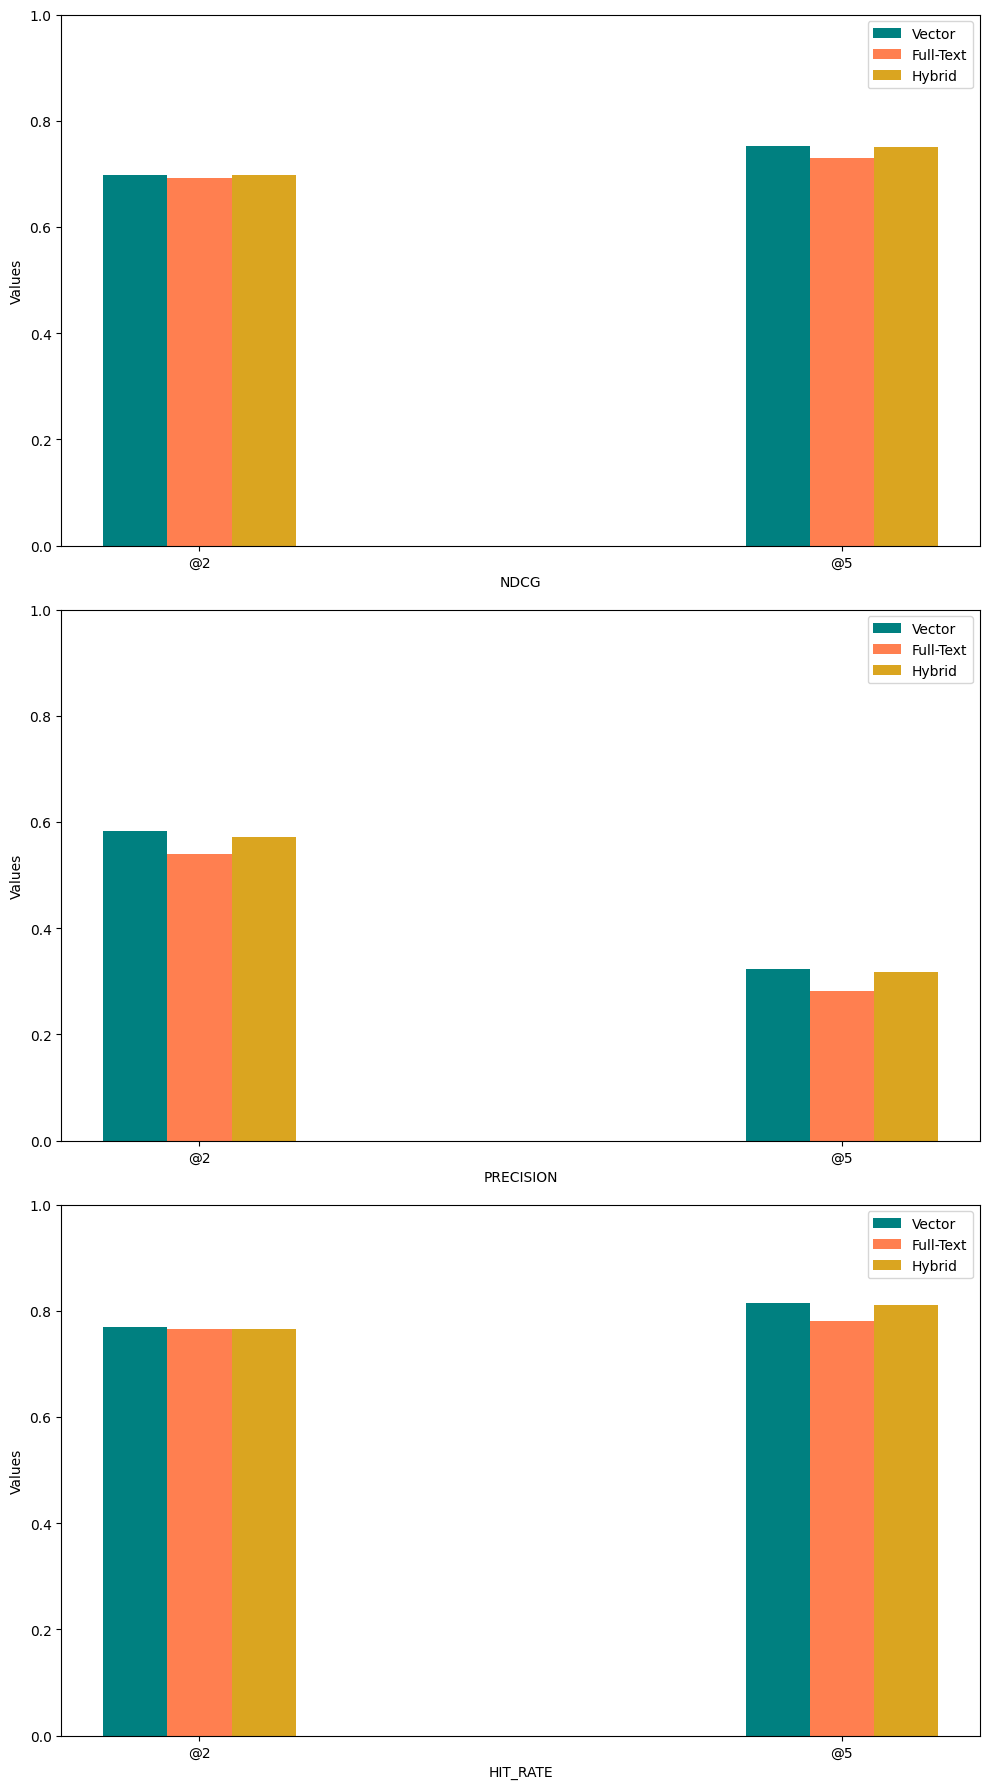

In [65]:
# Data for plotting
metrics = ["ndcg", "precision", "hit_rate"]
labels = ["@2", "@5"]
width = 0.1
x = np.arange(len(labels))

# Create the figure
fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Extract data for each instance
    at_2 = overall_metrics[f"{metric}_at_2"]
    at_5 = overall_metrics[f"{metric}_at_5"]

    # Plot data in grouped manner for @2 and @5
    ax.bar(x - width, [at_2[0], at_5[0]], width, color="teal")
    ax.bar(x, [at_2[1], at_5[1]], width, color="coral")
    ax.bar(x + width, [at_2[2], at_5[2]], width, color="goldenrod")

    # Set the labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel(f"{metric.upper()}")
    ax.set_ylabel("Values")
    ax.set_ylim(0,1)
    ax.legend(["Vector", "Full-Text", "Hybrid"])

# Display the plot
plt.tight_layout()
plt.show()